# Detect theta cycles

This is the notebook I used when writing the code to detect theta cycles.

The code is now organize as a Class called spikeA.Theta. 

There will be very high-level functions and low-level functions. 

At the very top is the high-level function that you can call to get your theta cycles. 
Below will be examples of how the low-level function work.

In [1]:
from spikeA.Dat_file_reader import Dat_file_reader
from spikeA.Session import Kilosort_session
from spikeA.Theta import Theta
import spikeA.spike_time


import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy import signal, ndimage
import scipy.stats as stats
from tqdm import tqdm
import pickle
from os import path

In [2]:
mouse="bt8564"
date="23072021"
name=f"{mouse}-{date}-0105"
path=f"/adata/electro/{mouse}/{name}/"

In [3]:
ses = Kilosort_session(name=name, path = path)
ses.load_parameters_from_files()
ses.file_names["dat"]

['/adata/electro/bt8564/bt8564-23072021-0105/bt8564-23072021_01.dat',
 '/adata/electro/bt8564/bt8564-23072021-0105/bt8564-23072021_02.dat',
 '/adata/electro/bt8564/bt8564-23072021-0105/bt8564-23072021_03.dat',
 '/adata/electro/bt8564/bt8564-23072021-0105/bt8564-23072021_04.dat',
 '/adata/electro/bt8564/bt8564-23072021-0105/bt8564-23072021_05.dat']

The objective is to detect theta cycles for theta epochs. Here are the steps

1. Calculate power in theta and delta range
2. Detect theta epochs, period when theta/delta power ratio is above a threshold
3. Detect individual oscillations at theta frequency during theta epochs.

I am using the same procedure as I had implemented in C++ in 2009, but this time in python.


## High-level functions

In [5]:
# create a theta object to do theta analysis
theta = Theta(session=ses)

In [6]:
%%time
#theta.detect_theta_cycles_one_session()

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 16.9 µs


In [7]:
theta.load_theta_epochs_and_cycles()

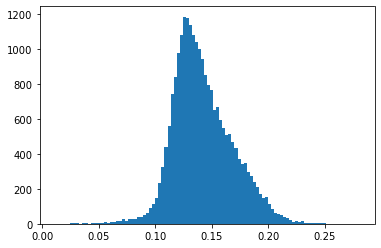

In [8]:
Spike_phase()

## Low-level functions

This code below can be used to debug the functions of the Theta class.

In [61]:
df = Dat_file_reader(file_names=[ses.file_names["dat"][0]], n_channels=ses.n_channels)
print(df)

<class 'spikeA.Dat_file_reader.Dat_file_reader'>
n_channels = 65
file_names = ['/adata/electro/bt8564/bt8564-23072021-0105/bt8564-23072021_01.dat']
size_of_files = [3280118400]
samples_per_file = [25231680]
total_samples = 25231680
files_first_sample = [0]
files_last_sample = [25231679]
start_sample_in_ram = None
max_sample_in_ram = None
ram_block_loaded = False


In [62]:
nSeconds= 60
data = df.get_data_one_block(start_sample=0, end_sample=int(ses.sampling_rate)*nSeconds, channels=np.asarray([0]))[0]

In [63]:
epochs, cycles = theta.detect_theta_cycles_one_channel(data)

### Calculate theta/delta ratio

In [66]:
thetaMinFreq = 4
thetaMaxFreq = 10
deltaMinFreq=2
deltaMaxFreq=4
thetaDeltaRatioThreshold=2
thetaEpochMinLengthMs=300
order = 2
convKernelSigmaMs=200

In [67]:
%%time
thetaPow = theta.calculate_oscillation_power(data, min_frequency=thetaMinFreq, max_frequency=thetaMaxFreq, 
                                       sampling_rate=ses.sampling_rate,order=2,conv_kernel_sigma_ms=200)
deltaPow = theta.calculate_oscillation_power(data, min_frequency=deltaMinFreq, max_frequency=deltaMaxFreq, 
                                       sampling_rate=ses.sampling_rate,order=2,conv_kernel_sigma_ms=200)
tdr = thetaPow/deltaPow

CPU times: user 119 ms, sys: 3.61 ms, total: 122 ms
Wall time: 120 ms


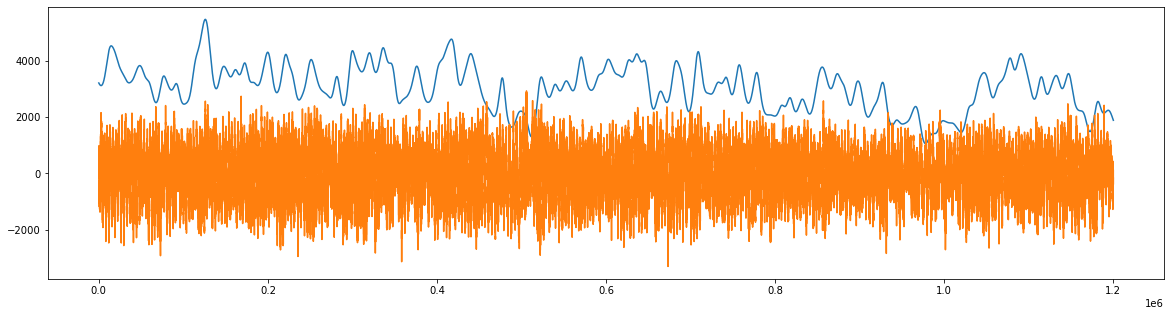

In [68]:
fig = plt.figure(figsize = (20,5))
plt.plot(tdr*1000)
plt.plot(data)
plt.show()


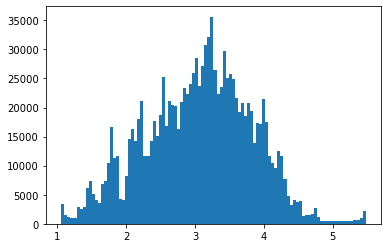

In [69]:
plt.hist(tdr,bins=100)
plt.show()

### Detect theta epocs

We can detect peaks that are above a predetermined threshold.

In [73]:
epochs = theta.detectThetaEpochs(theta_delta_ratio=tdr, 
                           theta_delta_ratio_threshold=thetaDeltaRatioThreshold,
                           theta_epoch_min_length_ms = thetaEpochMinLengthMs,
                           sampling_rate=ses.sampling_rate)
epochs

array([[      0,  483437],
       [ 494448,  505053],
       [ 516749,  934183],
       [ 959964,  970228],
       [1026189, 1166622],
       [1177401, 1198742]])

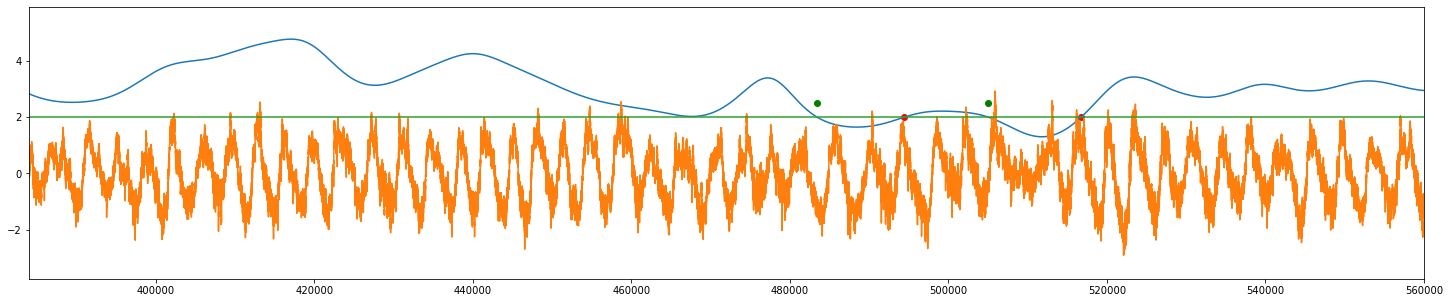

In [79]:
fig = plt.figure(figsize = (25,5))
plt.plot(tdr)
plt.plot(data/1000)
plt.plot([0,len(tdr)],[thetaDeltaRatioThreshold,thetaDeltaRatioThreshold],)
plt.scatter(epochs[:,0],tdr[epochs[:,0]],color="red")
plt.scatter(epochs[:,1],tdr[epochs[:,1]]+0.5,color="green")
plt.xlim(384000,560000)
plt.show()


### Detect the begining and end of individual theta cycles

In [80]:
filteredData = theta.butter_bandpass_filter(data = data, 
                       lowcut=thetaMinFreq, 
                       highcut=thetaMaxFreq, 
                       fs=ses.sampling_rate, 
                       order=order)
    

(200000.0, 300000.0)

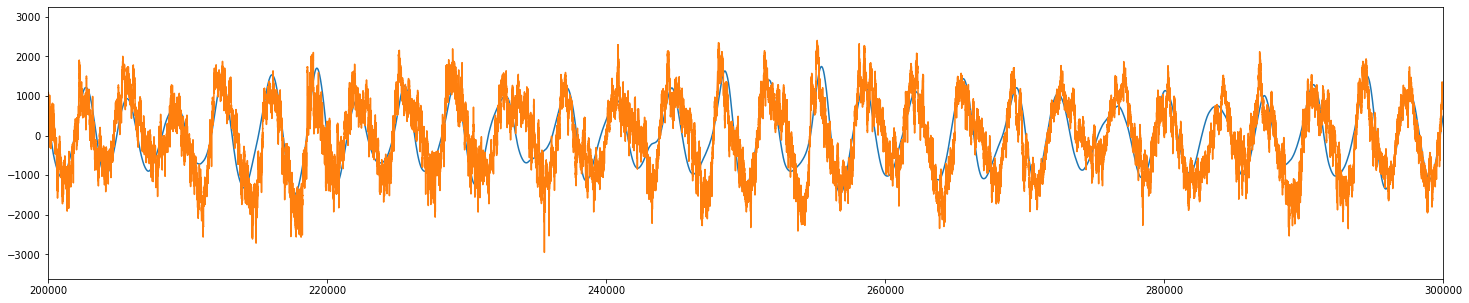

In [81]:
fig = plt.figure(figsize=(25,5))
plt.plot(filteredData)
plt.plot(data)
plt.xlim(200000,300000)

In [82]:
cycles = theta.detect_cycles_in_epochs(filteredData,epochs)

(200000.0, 300000.0)

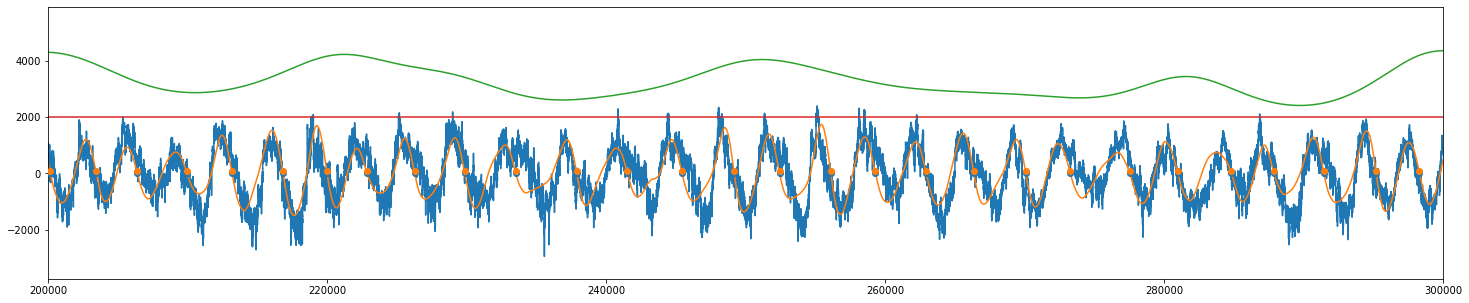

In [86]:
fig = plt.figure(figsize=(25,5))
#plt.plot(x*1000)

plt.plot(data)
plt.plot(filteredData)
plt.plot(tdr*1000)
plt.plot([0,len(tdr)],[thetaDeltaRatioThreshold*1000,thetaDeltaRatioThreshold*1000],)
plt.scatter(cycles[:,0],filteredData[cycles[:,0]],zorder=4)
plt.scatter(cycles[:,1],filteredData[cycles[:,1]]+100,zorder=4)
#plt.xlim()
plt.xlim(200000,300000)